# LSTM

In [3]:
VOCAB_SIZE = 300    # 사용할 단어 수
SEQ_LEN = 100       # 시퀀스 하나의 최대 길이

### 데이터 준비

In [4]:
# 데이터 로드
from tensorflow.keras.datasets import imdb

(train_input, train_target), (test_input, test_target) = imdb.load_data(num_words=VOCAB_SIZE)

17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [5]:
# PyTorch Tensor로 변환
import torch

train_input = [torch.tensor(seq, dtype=torch.long) for seq in train_input]
test_input = [torch.tensor(seq, dtype=torch.long) for seq in test_input]

train_target = torch.tensor(train_target, dtype=torch.long)
test_target = torch.tensor(test_target, dtype=torch.long)

print(len(train_input), len(test_input))
print(train_target.shape, test_target.shape)

25000 25000
torch.Size([25000]) torch.Size([25000])


In [6]:
train_input, test_input = train_input[:10000], test_input[:5000]
train_target, test_target = train_target[:10000], test_target[:5000]

In [18]:
train_input[0]

tensor([  1,  14,  22,  16,  43,   2,   2,   2,   2,  65,   2,   2,  66,   2,
          4, 173,  36, 256,   5,  25, 100,  43,   2, 112,  50,   2,   2,   9,
         35,   2, 284,   5, 150,   4, 172, 112, 167,   2,   2,   2,  39,   4,
        172,   2,   2,  17,   2,  38,  13,   2,   4, 192,  50,  16,   6, 147,
          2,  19,  14,  22,   4,   2,   2,   2,   4,  22,  71,  87,  12,  16,
         43,   2,  38,  76,  15,  13,   2,   4,  22,  17,   2,  17,  12,  16,
          2,  18,   2,   5,  62,   2,  12,   8,   2,   8, 106,   5,   4,   2,
          2,  16,   2,  66,   2,  33,   4, 130,  12,  16,  38,   2,   5,  25,
        124,  51,  36, 135,  48,  25,   2,  33,   6,  22,  12, 215,  28,  77,
         52,   5,  14,   2,  16,  82,   2,   8,   4, 107, 117,   2,  15, 256,
          4,   2,   7,   2,   5,   2,  36,  71,  43,   2,   2,  26,   2,   2,
         46,   7,   4,   2,   2,  13, 104,  88,   4,   2,  15, 297,  98,  32,
          2,  56,  26, 141,   6, 194,   2,  18,   4, 226,  22,  

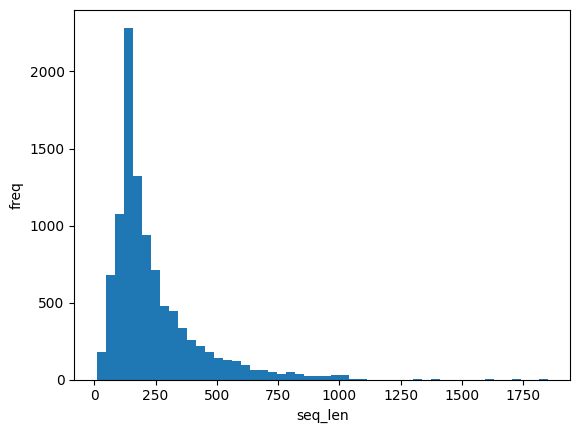

In [7]:
# 입력 데이터 길이 체크
import matplotlib.pyplot as plt
import numpy as np

train_len = [len(seq) for seq in train_input]

plt.hist(train_len, bins=50)
plt.xlabel('seq_len')
plt.ylabel('freq')
plt.show()

In [8]:
# padding 처리
import torch.nn.functional as F

def pad_sequences(sequences, maxlen, padding_value=0):
  padded_sequences = [F.pad(seq[:maxlen], (0, max(0, maxlen-len(seq))), value=padding_value) for seq in sequences]
  return torch.stack(padded_sequences)

train_seq = pad_sequences(train_input, maxlen=SEQ_LEN)
test_seq = pad_sequences(test_input, maxlen=SEQ_LEN)

train_seq.shape, test_seq.shape

(torch.Size([10000, 100]), torch.Size([5000, 100]))

In [9]:
# one-hot encoding
train_onehot = F.one_hot(train_seq, num_classes=VOCAB_SIZE).float()
test_onehot = F.one_hot(test_seq, num_classes=VOCAB_SIZE).float()

train_onehot.shape, test_onehot.shape

(torch.Size([10000, 100, 300]), torch.Size([5000, 100, 300]))

### 모델 준비 및 학습

##### one-hot encoding + LSTM

In [10]:
import torch
import torch.nn as nn

class SentimentLSTM(nn.Module):
  def __init__(self, seq_len, vocab_size, hidden_dim, output_dim):
    super(SentimentLSTM, self).__init__()
    self.lstm = nn.LSTM(input_size=vocab_size, hidden_size=hidden_dim, batch_first=True)
    self.fc = nn.Linear(hidden_dim, output_dim)
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    _, (hidden, _) = self.lstm(x)
    out = self.fc(hidden[-1])
    return self.sigmoid(out)

In [11]:
HIDDEN_DIM = 8
OUTPUT_DIM = 1

lstm_model = SentimentLSTM(seq_len=SEQ_LEN, vocab_size=VOCAB_SIZE, hidden_dim=HIDDEN_DIM, output_dim=OUTPUT_DIM)

print(lstm_model)

SentimentLSTM(
  (lstm): LSTM(300, 8, batch_first=True)
  (fc): Linear(in_features=8, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [12]:
total_params = 0
print(f"{'Layer':<20} {'Shape':<30} {'Params'}")
print("=" * 60)

for name, param in lstm_model.named_parameters():
  if param.requires_grad:
    param_count = param.numel()
    total_params += param_count
    print(f'{name:<20} {str(list(param.shape)):<30} {param_count}')

print("=" * 60)
print(f'Total Trainable Parameters: {total_params}')

Layer                Shape                          Params
lstm.weight_ih_l0    [32, 300]                      9600
lstm.weight_hh_l0    [32, 8]                        256
lstm.bias_ih_l0      [32]                           32
lstm.bias_hh_l0      [32]                           32
fc.weight            [1, 8]                         8
fc.bias              [1]                            1
Total Trainable Parameters: 9929


Epoch 1/100 | Train Loss: 0.5647, Train Acc: 0.7212, Val Loss: 0.5820, Val Acc: 0.7140
Epoch 2/100 | Train Loss: 0.5428, Train Acc: 0.7331, Val Loss: 0.5396, Val Acc: 0.7445
Epoch 3/100 | Train Loss: 0.5280, Train Acc: 0.7432, Val Loss: 0.5404, Val Acc: 0.7330
Epoch 4/100 | Train Loss: 0.5186, Train Acc: 0.7461, Val Loss: 0.5345, Val Acc: 0.7405
Epoch 5/100 | Train Loss: 0.5126, Train Acc: 0.7519, Val Loss: 0.5565, Val Acc: 0.7095
Epoch 6/100 | Train Loss: 0.5076, Train Acc: 0.7521, Val Loss: 0.5392, Val Acc: 0.7410
Epoch 7/100 | Train Loss: 0.4918, Train Acc: 0.7648, Val Loss: 0.5292, Val Acc: 0.7415
Epoch 8/100 | Train Loss: 0.4965, Train Acc: 0.7579, Val Loss: 0.5319, Val Acc: 0.7455
Epoch 9/100 | Train Loss: 0.4788, Train Acc: 0.7734, Val Loss: 0.5390, Val Acc: 0.7415
Epoch 10/100 | Train Loss: 0.4694, Train Acc: 0.7780, Val Loss: 0.5345, Val Acc: 0.7450
Epoch 11/100 | Train Loss: 0.4664, Train Acc: 0.7798, Val Loss: 0.5339, Val Acc: 0.7495
Epoch 12/100 | Train Loss: 0.4620, Train 

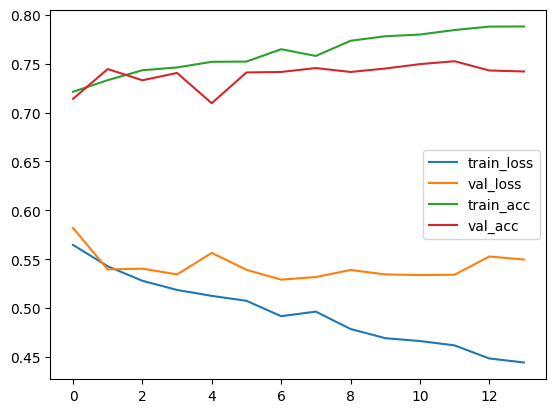

In [14]:
import torch.optim as optim
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset, random_split

# 배치 사이즈 설정 + 학습/검증셋 크기 설정
BATCH_SIZE = 65
train_size = int(len(train_onehot) * 0.8)
val_size = len(train_onehot) - train_size

# label 데이터 실수 처리
train_target = train_target.float()
test_target = test_target.float()

# 학습/검증셋 분할 + 미니배치로 사용하도록 DataLoader 생성
train_dataset, val_dataset = random_split(TensorDataset(train_onehot, train_target), [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

# epoch, 손실함수, 최적화함수 정의
epochs = 100
criterion = nn.BCELoss()
optimizer = optim.Adam(lstm_model.parameters(), lr=0.005)

# 시각화를 위한 손실값/정확도 저장용
train_losses, val_losses, train_accs, val_accs = [], [], [], []

# 조기종료 관련 변수 초기화
early_stopping_patience = 7
best_val_loss = float('inf')
early_stop_counter = 0

# 학습 과정
for epoch in range(epochs):
  # train mode
  lstm_model.train()
  total_loss, correct, total = 0, 0, 0

  for inputs, targets in train_loader:
    optimizer.zero_grad()              # 가중치 초기화
    outputs = lstm_model(inputs).squeeze()  # 순전파

    loss = criterion(outputs, targets) # 손실 계산

    loss.backward()                    # 역전파
    optimizer.step()                   # 가중치 업데이트
    total_loss += loss.item()

    pred = (outputs > 0.5).float()
    correct += (pred == targets).sum().item()
    total += targets.size(0)

  train_loss = total_loss / len(train_loader)
  train_acc = correct / total
  train_losses.append(train_loss)
  train_accs.append(train_acc)

  # validation mode
  lstm_model.eval()
  val_loss, val_correct, val_total = 0, 0, 0

  with torch.no_grad():
    for val_inputs, val_targets in val_loader:
      val_outputs = lstm_model(val_inputs).squeeze()
      loss = criterion(val_outputs, val_targets)
      val_loss += loss.item()

      val_pred = (val_outputs > 0.5).float()
      val_correct += (val_pred == val_targets).sum().item()
      val_total += val_targets.size(0)

  val_loss = val_loss / len(val_loader)
  val_acc = val_correct / val_total
  val_losses.append(val_loss)
  val_accs.append(val_acc)

  print(f'Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

  # 조기종료 처리
  if val_loss < best_val_loss:
    best_val_loss = val_loss
    early_stop_counter = 0
  else:
    early_stop_counter += 1
    if early_stop_counter >= early_stopping_patience:
      print("Early stopping 할게!")
      break

# 시각화
train_history_df = pd.DataFrame({
    "train_loss": train_losses,
    "val_loss": val_losses,
    "train_acc": train_accs,
    "val_acc": val_accs
})
train_history_df.plot()
plt.show()

In [15]:
def evaluate_model(model, test_loader, criterion):
  model.eval()
  val_loss, val_correct, val_total = 0, 0, 0

  with torch.no_grad():
    for val_inputs, val_targets in test_loader:
      val_outputs = model(val_inputs).squeeze()
      loss = criterion(val_outputs, val_targets)
      val_loss += loss.item()

      val_pred = (val_outputs > 0.5).float()
      val_correct += (val_pred == val_targets).sum().item()
      val_total += val_targets.size(0)

  test_loss = val_loss / len(test_loader)
  test_acc = val_correct / val_total
  return test_loss, test_acc

In [17]:
test_dataset = TensorDataset(test_onehot, test_target)
test_loader = DataLoader(test_dataset, batch_size=65)

loss, accuracy = evaluate_model(lstm_model, test_loader, criterion)

print(f'Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}')

Test Loss: 0.5869, Test Accuracy: 0.7166


##### Embedding + LSTM

In [19]:
import torch
import torch.nn as nn

class SentimentLSTM(nn.Module):
  def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
    super(SentimentLSTM, self).__init__()
    self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim)
    self.lstm = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_dim, batch_first=True)
    self.fc = nn.Linear(hidden_dim, output_dim)
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    x = self.embedding(x)
    _, (hidden, _) = self.lstm(x)
    out = self.fc(hidden[-1])
    return self.sigmoid(out)

In [26]:
HIDDEN_DIM = 8
OUTPUT_DIM = 1
EMBEDDING_DIM = 50

ebd_lstm_model = SentimentLSTM(vocab_size=VOCAB_SIZE, embedding_dim=EMBEDDING_DIM, hidden_dim=HIDDEN_DIM, output_dim=OUTPUT_DIM)

print(ebd_lstm_model)

SentimentLSTM(
  (embedding): Embedding(300, 50)
  (lstm): LSTM(50, 8, batch_first=True)
  (fc): Linear(in_features=8, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [21]:
total_params = 0
print(f"{'Layer':<20} {'Shape':<30} {'Params'}")
print("=" * 60)

for name, param in ebd_lstm_model.named_parameters():
  if param.requires_grad:
    param_count = param.numel()
    total_params += param_count
    print(f'{name:<20} {str(list(param.shape)):<30} {param_count}')

print("=" * 60)
print(f'Total Trainable Parameters: {total_params}')

Layer                Shape                          Params
embedding.weight     [300, 50]                      15000
lstm.weight_ih_l0    [32, 50]                       1600
lstm.weight_hh_l0    [32, 8]                        256
lstm.bias_ih_l0      [32]                           32
lstm.bias_hh_l0      [32]                           32
fc.weight            [1, 8]                         8
fc.bias              [1]                            1
Total Trainable Parameters: 16929


Epoch 1/100 | Train Loss: 0.6943, Train Acc: 0.4964, Val Loss: 0.6930, Val Acc: 0.5015
Epoch 2/100 | Train Loss: 0.6909, Train Acc: 0.5214, Val Loss: 0.6918, Val Acc: 0.5150
Epoch 3/100 | Train Loss: 0.6888, Train Acc: 0.5399, Val Loss: 0.6913, Val Acc: 0.5195
Epoch 4/100 | Train Loss: 0.6857, Train Acc: 0.5519, Val Loss: 0.6894, Val Acc: 0.5285
Epoch 5/100 | Train Loss: 0.6805, Train Acc: 0.5730, Val Loss: 0.6889, Val Acc: 0.5350
Epoch 6/100 | Train Loss: 0.6752, Train Acc: 0.5845, Val Loss: 0.6840, Val Acc: 0.5470
Epoch 7/100 | Train Loss: 0.6697, Train Acc: 0.5923, Val Loss: 0.6820, Val Acc: 0.5585
Epoch 8/100 | Train Loss: 0.6567, Train Acc: 0.6104, Val Loss: 0.6751, Val Acc: 0.5885
Epoch 9/100 | Train Loss: 0.6487, Train Acc: 0.6282, Val Loss: 0.6800, Val Acc: 0.5980
Epoch 10/100 | Train Loss: 0.6418, Train Acc: 0.6348, Val Loss: 0.6737, Val Acc: 0.5950
Epoch 11/100 | Train Loss: 0.6302, Train Acc: 0.6544, Val Loss: 0.6672, Val Acc: 0.6175
Epoch 12/100 | Train Loss: 0.6159, Train 

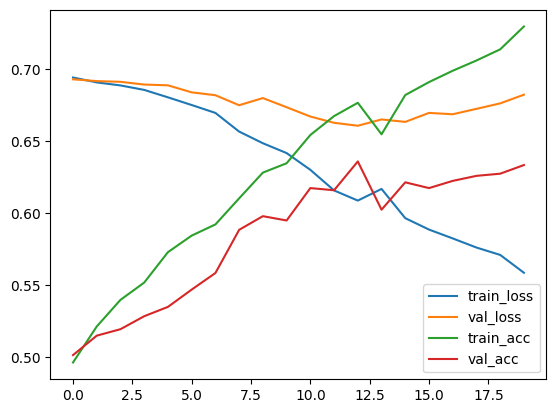

In [28]:
import torch.optim as optim
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset, random_split

# 배치 사이즈 설정 + 학습/검증셋 크기 설정
BATCH_SIZE = 65
train_size = int(len(train_seq) * 0.8)
val_size = len(train_seq) - train_size

train_target = train_target.to(torch.float32)
train_dataset, val_dataset = random_split(TensorDataset(train_seq.to(torch.long), train_target), [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

# epoch, 손실함수, 최적화함수 정의
epochs = 100
criterion = nn.BCELoss()
optimizer = optim.Adam(ebd_lstm_model.parameters(), lr=0.001)

# 시각화를 위한 손실값/정확도 저장용
train_losses, val_losses, train_accs, val_accs = [], [], [], []

# 조기종료 관련 변수 초기화
early_stopping_patience = 7
best_val_loss = float('inf')
early_stop_counter = 0

# 학습 과정
for epoch in range(epochs):
  # train mode
  ebd_lstm_model.train()
  total_loss, correct, total = 0, 0, 0

  for inputs, targets in train_loader:
    optimizer.zero_grad()              # 가중치 초기화
    outputs = ebd_lstm_model(inputs).squeeze()  # 순전파

    loss = criterion(outputs, targets) # 손실 계산

    loss.backward()                    # 역전파
    optimizer.step()                   # 가중치 업데이트
    total_loss += loss.item()

    pred = (outputs > 0.5).float()
    correct += (pred == targets).sum().item()
    total += targets.size(0)

  train_loss = total_loss / len(train_loader)
  train_acc = correct / total
  train_losses.append(train_loss)
  train_accs.append(train_acc)

  # validation mode
  ebd_lstm_model.eval()
  val_loss, val_correct, val_total = 0, 0, 0

  with torch.no_grad():
    for val_inputs, val_targets in val_loader:
      val_outputs = ebd_lstm_model(val_inputs).squeeze()
      loss = criterion(val_outputs, val_targets)
      val_loss += loss.item()

      val_pred = (val_outputs > 0.5).float()
      val_correct += (val_pred == val_targets).sum().item()
      val_total += val_targets.size(0)

  val_loss = val_loss / len(val_loader)
  val_acc = val_correct / val_total
  val_losses.append(val_loss)
  val_accs.append(val_acc)

  print(f'Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

  # 조기종료 처리
  if val_loss < best_val_loss:
    best_val_loss = val_loss
    early_stop_counter = 0
  else:
    early_stop_counter += 1
    if early_stop_counter >= early_stopping_patience:
      print("Early stopping 할게!")
      break

# 시각화
train_history_df = pd.DataFrame({
    "train_loss": train_losses,
    "val_loss": val_losses,
    "train_acc": train_accs,
    "val_acc": val_accs
})
train_history_df.plot()
plt.show()

In [29]:
def evaluate_model(model, test_loader, criterion):
  model.eval()
  val_loss, val_correct, val_total = 0, 0, 0

  with torch.no_grad():
    for val_inputs, val_targets in test_loader:
      val_outputs = model(val_inputs).squeeze()
      loss = criterion(val_outputs, val_targets)
      val_loss += loss.item()

      val_pred = (val_outputs > 0.5).float()
      val_correct += (val_pred == val_targets).sum().item()
      val_total += val_targets.size(0)

  test_loss = val_loss / len(test_loader)
  test_acc = val_correct / val_total
  return test_loss, test_acc

In [31]:
test_dataset = TensorDataset(test_seq.to(torch.long), test_target.to(torch.float32))
test_loader = DataLoader(test_dataset, batch_size=65)

loss, accuracy = evaluate_model(ebd_lstm_model, test_loader, criterion)

print(f'Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}')

Test Loss: 0.6605, Test Accuracy: 0.6454


##### Embedding + LSTM + LSTM

In [32]:
import torch
import torch.nn as nn

class SentimentLSTM(nn.Module):
  def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
    super(SentimentLSTM, self).__init__()
    self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim)
    self.lstm1 = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_dim, batch_first=True)
    self.lstm2 = nn.LSTM(input_size=hidden_dim, hidden_size=hidden_dim, batch_first=True)
    self.fc = nn.Linear(hidden_dim, output_dim)
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    x = self.embedding(x)
    x, _ = self.lstm1(x)
    _, (hidden, _) = self.lstm2(x)
    out = self.fc(hidden[-1])
    return self.sigmoid(out)

In [33]:
HIDDEN_DIM = 8
OUTPUT_DIM = 1
EMBEDDING_DIM = 50

ebd_lstm_model = SentimentLSTM(vocab_size=VOCAB_SIZE, embedding_dim=EMBEDDING_DIM, hidden_dim=HIDDEN_DIM, output_dim=OUTPUT_DIM)

print(ebd_lstm_model)

SentimentLSTM(
  (embedding): Embedding(300, 50)
  (lstm1): LSTM(50, 8, batch_first=True)
  (lstm2): LSTM(8, 8, batch_first=True)
  (fc): Linear(in_features=8, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [34]:
total_params = 0
print(f"{'Layer':<20} {'Shape':<30} {'Params'}")
print("=" * 60)

for name, param in ebd_lstm_model.named_parameters():
  if param.requires_grad:
    param_count = param.numel()
    total_params += param_count
    print(f'{name:<20} {str(list(param.shape)):<30} {param_count}')

print("=" * 60)
print(f'Total Trainable Parameters: {total_params}')

Layer                Shape                          Params
embedding.weight     [300, 50]                      15000
lstm1.weight_ih_l0   [32, 50]                       1600
lstm1.weight_hh_l0   [32, 8]                        256
lstm1.bias_ih_l0     [32]                           32
lstm1.bias_hh_l0     [32]                           32
lstm2.weight_ih_l0   [32, 8]                        256
lstm2.weight_hh_l0   [32, 8]                        256
lstm2.bias_ih_l0     [32]                           32
lstm2.bias_hh_l0     [32]                           32
fc.weight            [1, 8]                         8
fc.bias              [1]                            1
Total Trainable Parameters: 17505


Epoch 1/100 | Train Loss: 0.6655, Train Acc: 0.5926, Val Loss: 0.6766, Val Acc: 0.5595
Epoch 2/100 | Train Loss: 0.6474, Train Acc: 0.6282, Val Loss: 0.6661, Val Acc: 0.6100
Epoch 3/100 | Train Loss: 0.6204, Train Acc: 0.6599, Val Loss: 0.6716, Val Acc: 0.6345
Epoch 4/100 | Train Loss: 0.6253, Train Acc: 0.6576, Val Loss: 0.6390, Val Acc: 0.6505
Epoch 5/100 | Train Loss: 0.5941, Train Acc: 0.6926, Val Loss: 0.6387, Val Acc: 0.6360
Epoch 6/100 | Train Loss: 0.5632, Train Acc: 0.7190, Val Loss: 0.6332, Val Acc: 0.6595
Epoch 7/100 | Train Loss: 0.5437, Train Acc: 0.7311, Val Loss: 0.6182, Val Acc: 0.6850
Epoch 8/100 | Train Loss: 0.5222, Train Acc: 0.7514, Val Loss: 0.6228, Val Acc: 0.6820
Epoch 9/100 | Train Loss: 0.5115, Train Acc: 0.7588, Val Loss: 0.6130, Val Acc: 0.6900
Epoch 10/100 | Train Loss: 0.4953, Train Acc: 0.7682, Val Loss: 0.6314, Val Acc: 0.6835
Epoch 11/100 | Train Loss: 0.4872, Train Acc: 0.7675, Val Loss: 0.6451, Val Acc: 0.6805
Epoch 12/100 | Train Loss: 0.4770, Train 

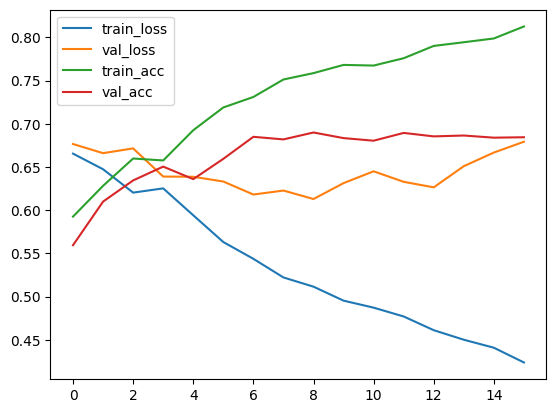

In [37]:
import torch.optim as optim
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset, random_split

# 배치 사이즈 설정 + 학습/검증셋 크기 설정
BATCH_SIZE = 65
train_size = int(len(train_seq) * 0.8)
val_size = len(train_seq) - train_size

train_target = train_target.to(torch.float32)
train_dataset, val_dataset = random_split(TensorDataset(train_seq.to(torch.long), train_target), [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

# epoch, 손실함수, 최적화함수 정의
epochs = 100
criterion = nn.BCELoss()
optimizer = optim.Adam(ebd_lstm_model.parameters(), lr=0.01)

# 시각화를 위한 손실값/정확도 저장용
train_losses, val_losses, train_accs, val_accs = [], [], [], []

# 조기종료 관련 변수 초기화
early_stopping_patience = 7
best_val_loss = float('inf')
early_stop_counter = 0

# 학습 과정
for epoch in range(epochs):
  # train mode
  ebd_lstm_model.train()
  total_loss, correct, total = 0, 0, 0

  for inputs, targets in train_loader:
    optimizer.zero_grad()              # 가중치 초기화
    outputs = ebd_lstm_model(inputs).squeeze()  # 순전파

    loss = criterion(outputs, targets) # 손실 계산

    loss.backward()                    # 역전파
    optimizer.step()                   # 가중치 업데이트
    total_loss += loss.item()

    pred = (outputs > 0.5).float()
    correct += (pred == targets).sum().item()
    total += targets.size(0)

  train_loss = total_loss / len(train_loader)
  train_acc = correct / total
  train_losses.append(train_loss)
  train_accs.append(train_acc)

  # validation mode
  ebd_lstm_model.eval()
  val_loss, val_correct, val_total = 0, 0, 0

  with torch.no_grad():
    for val_inputs, val_targets in val_loader:
      val_outputs = ebd_lstm_model(val_inputs).squeeze()
      loss = criterion(val_outputs, val_targets)
      val_loss += loss.item()

      val_pred = (val_outputs > 0.5).float()
      val_correct += (val_pred == val_targets).sum().item()
      val_total += val_targets.size(0)

  val_loss = val_loss / len(val_loader)
  val_acc = val_correct / val_total
  val_losses.append(val_loss)
  val_accs.append(val_acc)

  print(f'Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

  # 조기종료 처리
  if val_loss < best_val_loss:
    best_val_loss = val_loss
    early_stop_counter = 0
  else:
    early_stop_counter += 1
    if early_stop_counter >= early_stopping_patience:
      print("Early stopping 할게!")
      break

# 시각화
train_history_df = pd.DataFrame({
    "train_loss": train_losses,
    "val_loss": val_losses,
    "train_acc": train_accs,
    "val_acc": val_accs
})
train_history_df.plot()
plt.show()

In [38]:
test_dataset = TensorDataset(test_seq.to(torch.long), test_target.to(torch.float32))
test_loader = DataLoader(test_dataset, batch_size=65)

loss, accuracy = evaluate_model(ebd_lstm_model, test_loader, criterion)

print(f'Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}')

Test Loss: 0.6771, Test Accuracy: 0.6756


##### Embedding + LSTM + LSTM + Dropout

In [39]:
import torch
import torch.nn as nn

class SentimentLSTM(nn.Module):
  def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, dropout_rate):
    super(SentimentLSTM, self).__init__()
    self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim)
    self.lstm1 = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_dim, batch_first=True)
    self.dropout1 = nn.Dropout(p=dropout_rate)
    self.lstm2 = nn.LSTM(input_size=hidden_dim, hidden_size=hidden_dim, batch_first=True)
    self.dropout2 = nn.Dropout(p=dropout_rate)
    self.fc = nn.Linear(hidden_dim, output_dim)
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    x = self.embedding(x)
    x, _ = self.lstm1(x)
    x = self.dropout1(x)
    _, (hidden, _) = self.lstm2(x)
    x = self.dropout2(hidden[-1])
    out = self.fc(x)
    return self.sigmoid(out)

In [40]:
HIDDEN_DIM = 8
OUTPUT_DIM = 1
EMBEDDING_DIM = 50
DROPOUT_RATE = 0.3

ebd_lstm_model = SentimentLSTM(vocab_size=VOCAB_SIZE, embedding_dim=EMBEDDING_DIM, hidden_dim=HIDDEN_DIM,
                               output_dim=OUTPUT_DIM, dropout_rate=DROPOUT_RATE)

print(ebd_lstm_model)

SentimentLSTM(
  (embedding): Embedding(300, 50)
  (lstm1): LSTM(50, 8, batch_first=True)
  (dropout1): Dropout(p=0.3, inplace=False)
  (lstm2): LSTM(8, 8, batch_first=True)
  (dropout2): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=8, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [41]:
total_params = 0
print(f"{'Layer':<20} {'Shape':<30} {'Params'}")
print("=" * 60)

for name, param in ebd_lstm_model.named_parameters():
  if param.requires_grad:
    param_count = param.numel()
    total_params += param_count
    print(f'{name:<20} {str(list(param.shape)):<30} {param_count}')

print("=" * 60)
print(f'Total Trainable Parameters: {total_params}')

Layer                Shape                          Params
embedding.weight     [300, 50]                      15000
lstm1.weight_ih_l0   [32, 50]                       1600
lstm1.weight_hh_l0   [32, 8]                        256
lstm1.bias_ih_l0     [32]                           32
lstm1.bias_hh_l0     [32]                           32
lstm2.weight_ih_l0   [32, 8]                        256
lstm2.weight_hh_l0   [32, 8]                        256
lstm2.bias_ih_l0     [32]                           32
lstm2.bias_hh_l0     [32]                           32
fc.weight            [1, 8]                         8
fc.bias              [1]                            1
Total Trainable Parameters: 17505


Epoch 1/100 | Train Loss: 0.6924, Train Acc: 0.5246, Val Loss: 0.6867, Val Acc: 0.5495
Epoch 2/100 | Train Loss: 0.6731, Train Acc: 0.5938, Val Loss: 0.6677, Val Acc: 0.6080
Epoch 3/100 | Train Loss: 0.6515, Train Acc: 0.6410, Val Loss: 0.6426, Val Acc: 0.6400
Epoch 4/100 | Train Loss: 0.6299, Train Acc: 0.6600, Val Loss: 0.6465, Val Acc: 0.6505
Epoch 5/100 | Train Loss: 0.6116, Train Acc: 0.6903, Val Loss: 0.6187, Val Acc: 0.6690
Epoch 6/100 | Train Loss: 0.5957, Train Acc: 0.6946, Val Loss: 0.6097, Val Acc: 0.6930
Epoch 7/100 | Train Loss: 0.5670, Train Acc: 0.7188, Val Loss: 0.5868, Val Acc: 0.7005
Epoch 8/100 | Train Loss: 0.5588, Train Acc: 0.7309, Val Loss: 0.5893, Val Acc: 0.6980
Epoch 9/100 | Train Loss: 0.5451, Train Acc: 0.7360, Val Loss: 0.5983, Val Acc: 0.7020
Epoch 10/100 | Train Loss: 0.5403, Train Acc: 0.7455, Val Loss: 0.5919, Val Acc: 0.7085
Epoch 11/100 | Train Loss: 0.5248, Train Acc: 0.7491, Val Loss: 0.5933, Val Acc: 0.6960
Epoch 12/100 | Train Loss: 0.5202, Train 

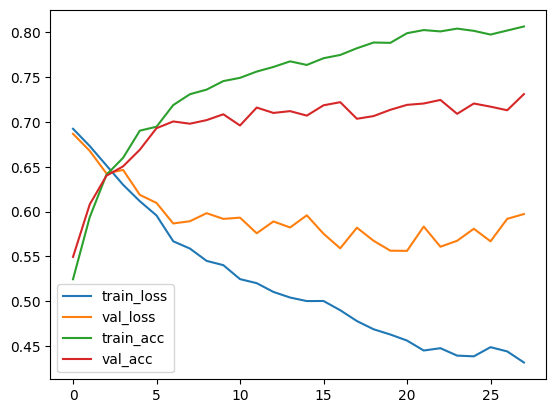

In [42]:
import torch.optim as optim
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset, random_split

# 배치 사이즈 설정 + 학습/검증셋 크기 설정
BATCH_SIZE = 65
train_size = int(len(train_seq) * 0.8)
val_size = len(train_seq) - train_size

train_target = train_target.to(torch.float32)
train_dataset, val_dataset = random_split(TensorDataset(train_seq.to(torch.long), train_target), [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

# epoch, 손실함수, 최적화함수 정의
epochs = 100
criterion = nn.BCELoss()
optimizer = optim.Adam(ebd_lstm_model.parameters(), lr=0.01)

# 시각화를 위한 손실값/정확도 저장용
train_losses, val_losses, train_accs, val_accs = [], [], [], []

# 조기종료 관련 변수 초기화
early_stopping_patience = 7
best_val_loss = float('inf')
early_stop_counter = 0

# 학습 과정
for epoch in range(epochs):
  # train mode
  ebd_lstm_model.train()
  total_loss, correct, total = 0, 0, 0

  for inputs, targets in train_loader:
    optimizer.zero_grad()              # 가중치 초기화
    outputs = ebd_lstm_model(inputs).squeeze()  # 순전파

    loss = criterion(outputs, targets) # 손실 계산

    loss.backward()                    # 역전파
    optimizer.step()                   # 가중치 업데이트
    total_loss += loss.item()

    pred = (outputs > 0.5).float()
    correct += (pred == targets).sum().item()
    total += targets.size(0)

  train_loss = total_loss / len(train_loader)
  train_acc = correct / total
  train_losses.append(train_loss)
  train_accs.append(train_acc)

  # validation mode
  ebd_lstm_model.eval()
  val_loss, val_correct, val_total = 0, 0, 0

  with torch.no_grad():
    for val_inputs, val_targets in val_loader:
      val_outputs = ebd_lstm_model(val_inputs).squeeze()
      loss = criterion(val_outputs, val_targets)
      val_loss += loss.item()

      val_pred = (val_outputs > 0.5).float()
      val_correct += (val_pred == val_targets).sum().item()
      val_total += val_targets.size(0)

  val_loss = val_loss / len(val_loader)
  val_acc = val_correct / val_total
  val_losses.append(val_loss)
  val_accs.append(val_acc)

  print(f'Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

  # 조기종료 처리
  if val_loss < best_val_loss:
    best_val_loss = val_loss
    early_stop_counter = 0
  else:
    early_stop_counter += 1
    if early_stop_counter >= early_stopping_patience:
      print("Early stopping 할게!")
      break

# 시각화
train_history_df = pd.DataFrame({
    "train_loss": train_losses,
    "val_loss": val_losses,
    "train_acc": train_accs,
    "val_acc": val_accs
})
train_history_df.plot()
plt.show()

In [43]:
test_dataset = TensorDataset(test_seq.to(torch.long), test_target.to(torch.float32))
test_loader = DataLoader(test_dataset, batch_size=65)

loss, accuracy = evaluate_model(ebd_lstm_model, test_loader, criterion)

print(f'Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}')

Test Loss: 0.6226, Test Accuracy: 0.7116
